## Tensorflow tutorial

https://mlnotebook.github.io/post/tensorflow-basics/

The idea of ‘flow’ is central to TF’s organisation. The actual CNN is written as a ‘graph’. A graph is simply a list of the differnet layers in your network each with their own input and output.

In [32]:
# Import libraries
import numpy as np
import tensorflow as tf
from tensorflow.contrib import learn
from tensorflow.contrib.learn.python.learn.estimators import model_fn as model_fn_lib

We gaan de MNIST dataset bekijken. Een dataset met handgeschreven getallen inclusief labels om te gebruiken als traindata.

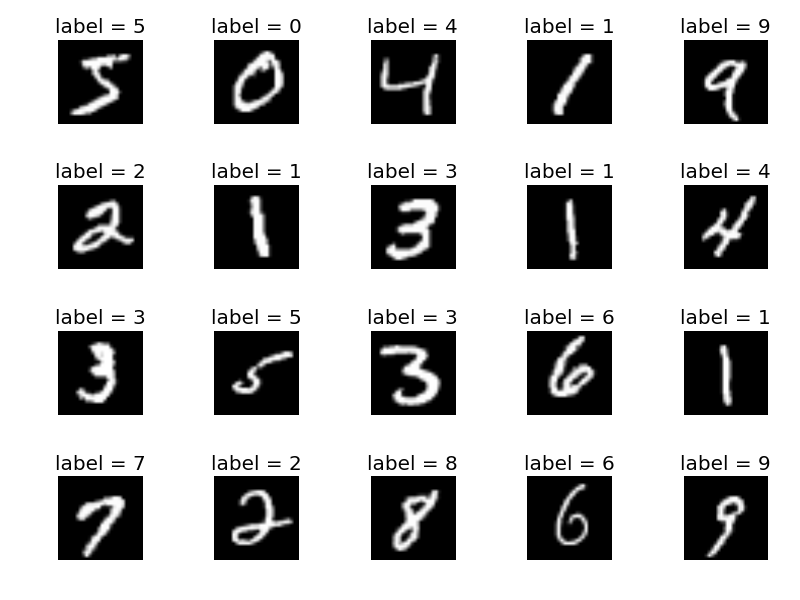

### Netwerk eigenschappen:
2 convolutional layers learning 16 filters (or kernels) of (3 x 3)

2 max-pooling layers that half the size of the image using (2 x 2) kernel

A fully connected layer at the end.

De data moet eerst reshaped worden, omdat in de MNIST database alle objecten als een lange vector zijn opgeslagen. Iedere layer moet vervolgens weten wat het formaat is dat ie kan verwachten als input en wat de output moet zijn.

### Voorbeeld reshaping data

Omdat TensorFlow zijn eigen datatype gebruikt, een Tensor, moeten we de functie tf.reshape() gebruiken om het juiste formaat te krijgen. Dit is vergelijkbaar met numpy.reshape()

In [5]:
# numpy
a = np.arange(6).reshape((3, 2))
print(a)
a_reshaped = np.reshape(a, (2, 3))
print(a_reshaped)

[[0 1]
 [2 3]
 [4 5]]
[[0 1 2]
 [3 4 5]]


In Tensorflow is de eerste parameter dus de tensor die je wilt reshapen. Daarna volgt het formaat. 

In [20]:
# Tensorflow
sess = tf.InteractiveSession()

a = tf.constant([[0, 1], [2, 3], [4, 5]])
a.eval()

array([[0, 1, 2],
       [3, 4, 5]], dtype=int32)

In [18]:
sess = tf.InteractiveSession()
a_reshaped = tf.reshape(a, [2, 3])
a_reshaped.eval()

array([[0, 1, 2],
       [3, 4, 5]], dtype=int32)

### Hyperparameters and layer definition

In [38]:
#Hyperparameters
numK = 16               #number of kernels in each conv layer
sizeConvK = 3           #size of the kernels in each conv layer [n x n]
sizePoolK = 2           #size of the kernels in each pool layer [m x m]
inputSize = 28          #size of the input image
numChannels = 1         #number of channels to the input image grayscale=1, RGB=3
keepProb = 0.4      
learning_rate = 0.001

### Convolutional and Pooling layers

#### Convolutional layer
Je ziet hier een aatal parameters terugkomen:
    1. aantal filters (16)
    2. grootte filter (3x3)
    3. strides (1x1)
    4. geen zero_padding, dus grootte blijft gelijk
    5. gebruikte activation functie: ReLu = max(x,0)
    
#### Pooling layer
Ook hier de parameters:
    1. grootte (2x2) dus de afbeeldingen worden 2x zo klein.
    2. strides (2), dus je slaat een plek over. Alleen een integer (2) invullen heeft dezelfde betekenis als (2,2)

In [34]:
def doConv(inputs):
    convOut = tf.layers.conv2d(inputs=inputs, filters=numK, kernel_size=[sizeConvK, sizeConvK], 
                               strides = (1, 1), padding="same", activation=tf.nn.relu)    
    return convOut
    
def doPool(inputs):
    poolOut = tf.layers.max_pooling2d(inputs=inputs, pool_size=[sizePoolK, sizePoolK], strides=2)
    return poolOut

Dit is de definitie van het convolutional neural network. Nu moeten we er traindata instoppen, Tensorflow het netwerk laten runnen, output genereren en dit vergelijken met de labels uit de traindata.

In [35]:
def convNet(inputs, labels, mode):
    #reshape the input from a vector to a 2D image
    input_layer = tf.reshape(inputs, [-1, inputSize, inputSize, numChannels])  # [-1]: do this for the whole batch
    
    #perform convolution and pooling
    conv1 = doConv(input_layer) 
    pool1 = doPool(conv1)      
    
    conv2 = doConv(pool1)
    pool2 = doPool(conv2)

    #flatted the result back to a vector for the FC layer
    flatPool = tf.reshape(pool2, [-1, 7 * 7 * numK])    
    dense = tf.layers.dense(inputs=flatPool, units=1024, activation=tf.nn.relu)
    
     #Get the output in the form of one-hot labels with x units
    logits = tf.layers.dense(inputs=dense, units=10) 
    
    loss = None
    train_op = None
    #At the end of the network, check how well we did     
    if mode != learn.ModeKeys.INFER:
        #create one-hot tabels from the training-labels
        onehot_labels = tf.one_hot(indices=tf.cast(labels, tf.int32), depth=10)
        #check how close the output is to the training-labels
        loss = tf.losses.softmax_cross_entropy(onehot_labels=onehot_labels, logits=logits)
    
    #After checking the loss, use it to train the network weights   
    if mode == learn.ModeKeys.TRAIN:
        train_op = tf.contrib.layers.optimize_loss(loss=loss, global_step=tf.contrib.framework.get_global_step(), 
                                                   learning_rate=learning_rate, optimizer="SGD")
        
    predictions ={"classes": tf.argmax(input=logits, axis=1), 
                  "probabilities": tf.nn.softmax(logits, name="softmax_tensor")}
    
    return model_fn_lib.ModelFnOps(mode=mode, predictions=predictions, loss=loss, train_op=train_op)

In de laatste regel kun je in 1 stap de ReLu functie toepassen op de 7x7x16 input uit de laatste pooling layer en je krijgt 1.024 units terug.

### Output

Het netwerk zal kansen genereren. Dit moet worden omgezet, zodat iedere waarde zijn eigen box heeft waaraan een kans kan worden toegekend. Dit wordt gedaan met one-hot labels. Zo is de klasse 3 [0,0,0,1,0,0,0,0,0,0]. Op die manier wordt niet voorspeld wat het getal is, maar kan de kans worden bepaald dat een input tot een bepaalde klasse behoort.

### Toelichting op stappen in de functie

#### logits
De variabele logits wordt verkregen uit de variabele dense die eerder in de full-connected layer gedefinieerd is.

#### learn.ModeKeys
Tensorflow.contrib.learn heeft drie standaard voor de toestand van een model: INFER (Inference, TRAIN, EVAL). Dit wordt hier gebruikt om te bepalen wat de actie is. Als er getraind wordt, dan wordt de loss geoptimaliseerd.

#### one-hot en loss functie
Vervolgens start met 'lege' variabelen. 
Daarna worden de one-hot labels gemaakt uit de traindata m.b.v. de functie tf.one_hot(). Deze vergelijken we met de berekende logits. Dat geberut met een softmax cross-entropy functie. De uitkomst is onze loss. Je hebt hiervoor heel veel opties of je kunt zelf een loss functie schrijven. Eenvoudigste is het absolute verschil.

#### optimaliseren
Het optimaliseren gebeurt o.b.v. deze loss met tf.contrib.layers.optimize_loss(). Het probeert de minimale waarden voor de loss te vinden. Hier zijn 4 parameters gebruikt, maar je kunt er veel meer toepassen:

optimize_loss(
    loss,
    global_step,
    learning_rate,
    optimizer,
    gradient_noise_scale=None,
    gradient_multipliers=None,
    clip_gradients=None,
    learning_rate_decay_fn=None,
    update_ops=None,
    variables=None,
    name=None,
    summaries=None,
    colocate_gradients_with_ops=False,
    increment_global_step=True
)

De optimizer SGD is Stochastic Gradient Descent, vergelijkbaar met de theorie van regulier nn.

#### predictions
arg_max bepaalt de index van de grootste waarde

In [25]:
arg_max_voorbeeld = np.arange(6).reshape((3, 2))
arg_max_totaal = np.argmax(arg_max_voorbeeld)
arg_max_rij = np.argmax(arg_max_voorbeeld, axis=1)
arg_max_kolom = np.argmax(arg_max_voorbeeld, axis=0)
print(arg_max_totaal)
print(arg_max_rij)
print(arg_max_kolom)

5
[1 1 1]
[2 2]


### Run the script

In [36]:
def main(unused_argv):
    # Load training and eval data
    mnist = learn.datasets.load_dataset("mnist")
    train_data = mnist.train.images # Returns np.array
    train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
    eval_data = mnist.test.images # Returns np.array
    eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)
    
    mnistClassifier = learn.Estimator(model_fn=convNet,   model_dir="/tmp/mln_MNIST2")
    
    tensors2log = {"probabilities": "softmax_tensor"}
    logging_hook = tf.train.LoggingTensorHook(tensors=tensors2log, every_n_iter=100)
    
    mnistClassifier.fit(x=train_data, y=train_labels, batch_size=100, steps=1000, monitors=[logging_hook])

    metrics = {"accuracy": learn.MetricSpec(metric_fn=tf.metrics.accuracy, prediction_key="classes")}
    
    eval_results = mnistClassifier.evaluate(x=eval_data, y=eval_labels, metrics=metrics)
    print(eval_results)

### Toelichting

Allereerst wordt de data geladen.
De probailities worden gelogd via de variabele tensor2log en dat gebeurt iedere 100 iteraties.

Definieer het aantal iteraties en de batch size van het aantal images dat je tegelijk traint.

Tot slot gebruik je .evaluate() om de resultaten te bekijken.

### Check out the data first

In [26]:
# Load training and eval data
mnist = learn.datasets.load_dataset("mnist")
train_data = mnist.train.images # Returns np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
eval_data = mnist.test.images # Returns np.array
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST-data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


In [29]:
train_data[0:5]

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [31]:
train_data.shape

(55000, 784)

In [40]:
tf.app.run(main)

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_id': 0, '_model_dir': None, '_save_checkpoints_steps': None, '_environment': 'local', '_keep_checkpoint_max': 5, '_task_type': None, '_evaluation_master': '', '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 0, '_save_checkpoints_secs': 600, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_num_ps_replicas': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x12a6e4710>, '_is_chief': True, '_save_summary_steps': 100, '_keep_checkpoint_every_n_hours': 10000}
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator

/Users/olafdeleeuw/anaconda/lib/python3.5/site-packages/tensorflow/python/util/deprecation.py:248: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/mln_MNIST2/model.ckpt.
INFO:tensorflow:loss = 2.29006, step = 1
INFO:tensorflow:probabilities = [[ 0.10361629  0.09895618  0.11328626  0.10101365  0.09576016  0.09722909
   0.09549352  0.09391432  0.10045427  0.1002763 ]
 [ 0.10549587  0.09057717  0.1105076   0.10486691  0.09744035  0.09693684
   0.09791041  0.0964387   0.10769454  0.09213161]
 [ 0.10302437  0.09532619  0.10768338  0.10181398  0.09642982  0.10189807
   0.1017363   0.09298536  0.09857498  0.10052754]
 [ 0.10818525  0.08692829  0.10303075  0.09598862  0.09551056  0.09852293
   0.10091486  0.09568675  0.11383776  0.10139427]
 [ 0.10585737  0.09812964  0.10822611  0.10049012  0.09906387  0.10455196
   0.09543256  0.09268041  0.0980166   0.09755137]
 [ 0.10396525  0.09722106  0.10387556  0.10505616  0.10082958  0.10073638
   0.09443286  0.09815528  0.09846318  0.09726465]
 [ 0.10359455  0.09608731  0.1091471   0.10660197  0.096188

INFO:tensorflow:global_step/sec: 23.7613
INFO:tensorflow:loss = 2.28437, step = 101 (4.210 sec)
INFO:tensorflow:probabilities = [[ 0.09937356  0.08881497  0.12342423  0.09492397  0.09666515  0.09938557
   0.10473     0.09477428  0.10210383  0.0958044 ]
 [ 0.10753465  0.09169776  0.10995109  0.09862574  0.09683355  0.09795013
   0.10111225  0.09311521  0.10766892  0.09551077]
 [ 0.1026397   0.09682282  0.10515326  0.11204863  0.09749892  0.1027595
   0.1024103   0.09370539  0.09422528  0.09273622]
 [ 0.10012851  0.0910324   0.10826343  0.09704494  0.09546589  0.09940308
   0.09753496  0.09735653  0.10950713  0.10426309]
 [ 0.10064849  0.08848298  0.11509695  0.09477125  0.09516118  0.09567059
   0.10328077  0.09350754  0.10967926  0.10370111]
 [ 0.1002466   0.0897461   0.1097855   0.1021532   0.09699942  0.0983192
   0.10031036  0.09886082  0.10821486  0.09536396]
 [ 0.11168321  0.09164491  0.10624508  0.09788101  0.0942189   0.09720534
   0.10763101  0.09419483  0.10636988  0.09292586]

INFO:tensorflow:global_step/sec: 26.2636
INFO:tensorflow:loss = 2.28069, step = 201 (3.808 sec)
INFO:tensorflow:probabilities = [[ 0.10788484  0.09062904  0.1067919   0.09445904  0.09816352  0.09907459
   0.10631203  0.0945227   0.10726128  0.09490111]
 [ 0.10747481  0.09203018  0.11181159  0.09774083  0.10100762  0.09453524
   0.09668246  0.09215467  0.10826473  0.09829786]
 [ 0.1089217   0.09203511  0.10268185  0.11278086  0.09481569  0.09755159
   0.09539907  0.09869922  0.10290483  0.09421004]
 [ 0.10346735  0.09549281  0.10127469  0.10462578  0.09588423  0.10195389
   0.10066029  0.09367233  0.10652569  0.09644305]
 [ 0.09999635  0.09394968  0.10784733  0.10780128  0.09436134  0.09364285
   0.10251542  0.09890281  0.10746533  0.09351774]
 [ 0.1006451   0.08692748  0.11331873  0.09903137  0.09766009  0.0955512
   0.10681739  0.09788461  0.10799343  0.09417059]
 [ 0.1052919   0.08946067  0.10702881  0.1007425   0.09637336  0.08683426
   0.10748545  0.09000655  0.11465336  0.10212315

INFO:tensorflow:global_step/sec: 25.3419
INFO:tensorflow:loss = 2.26231, step = 301 (3.946 sec)
INFO:tensorflow:probabilities = [[ 0.10877258  0.08911214  0.11060897  0.10319744  0.09722143  0.08781911
   0.1028751   0.08698191  0.11817853  0.09523286]
 [ 0.10578048  0.09263133  0.11130709  0.10345899  0.09566668  0.09400644
   0.10014801  0.09511227  0.10589642  0.0959924 ]
 [ 0.1060413   0.08656176  0.10984629  0.09918476  0.09533561  0.09690768
   0.10617981  0.09347445  0.10905749  0.09741097]
 [ 0.10458168  0.09948941  0.0981274   0.09915543  0.0979817   0.1025386
   0.09782545  0.09172527  0.10717749  0.10139758]
 [ 0.10924517  0.08997316  0.10500855  0.10469415  0.09476899  0.09866454
   0.1074219   0.08660556  0.10766577  0.09595224]
 [ 0.10319468  0.0925044   0.10480358  0.10687484  0.09786332  0.0975771
   0.09820618  0.09799056  0.10535695  0.09562831]
 [ 0.11462161  0.08637774  0.11226258  0.09893752  0.09031376  0.09251328
   0.10508423  0.0998495   0.109777    0.09026277]

INFO:tensorflow:global_step/sec: 24.1628
INFO:tensorflow:loss = 2.25236, step = 401 (4.138 sec)
INFO:tensorflow:probabilities = [[ 0.1077996   0.09317067  0.10151836  0.09804051  0.10092314  0.10183362
   0.1029849   0.09151421  0.1046894   0.0975256 ]
 [ 0.10451651  0.089995    0.11180713  0.1052909   0.09345277  0.09727991
   0.10312682  0.09762734  0.1049652   0.09193837]
 [ 0.10214797  0.09663378  0.10485721  0.10875119  0.0917793   0.09977852
   0.10199659  0.08876561  0.10843839  0.09685145]
 [ 0.1023455   0.10210346  0.10084342  0.10226923  0.09518654  0.10083881
   0.10165875  0.09307988  0.10416239  0.097512  ]
 [ 0.10636054  0.08589756  0.1057949   0.10416781  0.10255412  0.09587837
   0.10170668  0.09185727  0.10853524  0.09724743]
 [ 0.10158861  0.09007531  0.10664042  0.09703021  0.09627429  0.09920453
   0.09441974  0.10503414  0.10935419  0.10037854]
 [ 0.10929556  0.09258887  0.11082002  0.1055485   0.09296277  0.09495389
   0.09861428  0.09369762  0.10681852  0.0946999

INFO:tensorflow:global_step/sec: 24.7833
INFO:tensorflow:loss = 2.23853, step = 501 (4.035 sec)
INFO:tensorflow:probabilities = [[ 0.11158062  0.08352499  0.11713521  0.09902097  0.09454526  0.09835181
   0.1057504   0.0901777   0.10875677  0.09115626]
 [ 0.1026817   0.09293311  0.10817244  0.10576961  0.09431492  0.09387861
   0.09652171  0.10386186  0.11080009  0.09106596]
 [ 0.10367776  0.08749333  0.10408644  0.09565813  0.09746384  0.0991928
   0.08787679  0.10733137  0.10417908  0.11304039]
 [ 0.10783061  0.0872121   0.09707195  0.09946485  0.09276263  0.09717031
   0.09465299  0.10514128  0.11231777  0.10637553]
 [ 0.11897498  0.07610756  0.11234242  0.09571613  0.09718937  0.09259018
   0.10379364  0.08872484  0.11234528  0.1022157 ]
 [ 0.11097306  0.08329397  0.10847519  0.09274586  0.1027635   0.09347968
   0.09608447  0.09879339  0.10639147  0.10699945]
 [ 0.10237653  0.08120821  0.11925491  0.10952701  0.09558247  0.08696472
   0.10835506  0.09189359  0.114142    0.0906955 

INFO:tensorflow:global_step/sec: 24.8401
INFO:tensorflow:loss = 2.22884, step = 601 (4.026 sec)
INFO:tensorflow:probabilities = [[ 0.11217225  0.08560979  0.10919809  0.09841995  0.10249067  0.10292292
   0.09355021  0.09699454  0.09653413  0.10210738]
 [ 0.11222985  0.08628901  0.10768542  0.10092643  0.09720642  0.09351341
   0.09961101  0.09013558  0.10810483  0.10429805]
 [ 0.1184402   0.08290966  0.10813433  0.10177089  0.09352364  0.09418776
   0.10818331  0.09296381  0.10646664  0.09341976]
 [ 0.10843087  0.09267128  0.1071313   0.11111348  0.10019879  0.0952388
   0.09771133  0.09365871  0.10446447  0.089381  ]
 [ 0.10270182  0.10371618  0.10004811  0.10146869  0.09338697  0.10357393
   0.09439141  0.09440609  0.10441852  0.10188831]
 [ 0.10929714  0.0842362   0.10585852  0.09774102  0.09565695  0.09967411
   0.1003865   0.09700677  0.10805928  0.10208355]
 [ 0.10026045  0.09107684  0.10005318  0.10032716  0.0925329   0.09832287
   0.09380757  0.10938907  0.10741076  0.10681922

INFO:tensorflow:global_step/sec: 24.6335
INFO:tensorflow:loss = 2.21841, step = 701 (4.060 sec)
INFO:tensorflow:probabilities = [[ 0.10220463  0.09723362  0.09901793  0.09995814  0.09581284  0.09672581
   0.09198681  0.09647347  0.11015877  0.11042801]
 [ 0.111767    0.09260817  0.10432376  0.10677074  0.09619854  0.09302329
   0.1004647   0.09302895  0.11082371  0.09099115]
 [ 0.11783029  0.08961716  0.10123837  0.10819799  0.09034463  0.09957934
   0.10988054  0.08683407  0.10336395  0.09311359]
 [ 0.12236307  0.07726831  0.10745032  0.10815597  0.088134    0.08851969
   0.099011    0.10155217  0.09897603  0.1085695 ]
 [ 0.11996123  0.0702952   0.11143285  0.0963611   0.09638632  0.08240197
   0.11830118  0.08901563  0.12036151  0.09548303]
 [ 0.10732091  0.08279233  0.11761481  0.09891216  0.09879114  0.08467149
   0.09914675  0.10618496  0.11157744  0.09298798]
 [ 0.11748876  0.08542183  0.10621991  0.12560992  0.09140109  0.08787184
   0.09998143  0.09184939  0.1075221   0.0866337

INFO:tensorflow:global_step/sec: 24.7569
INFO:tensorflow:loss = 2.19978, step = 801 (4.039 sec)
INFO:tensorflow:probabilities = [[ 0.10890137  0.09066958  0.09383871  0.09780762  0.098051    0.09291141
   0.09445374  0.09642192  0.10989273  0.11705188]
 [ 0.10851934  0.08164063  0.1076162   0.12068357  0.08665286  0.09737697
   0.10178238  0.09399488  0.10905948  0.09267366]
 [ 0.12418364  0.07505725  0.10652938  0.10463113  0.08888309  0.08684436
   0.12256087  0.08076491  0.11430735  0.09623798]
 [ 0.11306803  0.0876027   0.10026255  0.10524487  0.09027687  0.09711336
   0.10844728  0.08864482  0.11323913  0.09610033]
 [ 0.10793171  0.09360815  0.10225337  0.10518376  0.09159608  0.09488381
   0.09513958  0.09119011  0.1126269   0.10558647]
 [ 0.10519271  0.09297403  0.11093172  0.11134548  0.08856654  0.09074587
   0.09580866  0.10020113  0.11571381  0.08852001]
 [ 0.11732484  0.07908023  0.09805793  0.0990843   0.09724963  0.09614286
   0.1045545   0.09325806  0.10540644  0.1098412

INFO:tensorflow:global_step/sec: 24.5432
INFO:tensorflow:loss = 2.18369, step = 901 (4.074 sec)
INFO:tensorflow:probabilities = [[ 0.10606475  0.08549087  0.11456858  0.12342051  0.08303163  0.09023028
   0.09194259  0.1067967   0.10693105  0.09152296]
 [ 0.10554167  0.08186407  0.10240331  0.09609059  0.09882965  0.09242822
   0.09721299  0.09801061  0.11804835  0.1095706 ]
 [ 0.10717513  0.08334971  0.10147804  0.10170482  0.1021494   0.09339665
   0.10085312  0.09393609  0.10686347  0.10909358]
 [ 0.11331864  0.07613604  0.10010338  0.09211245  0.09930611  0.08995441
   0.10099042  0.10244007  0.10958964  0.11604885]
 [ 0.14904866  0.06186559  0.13587423  0.11344496  0.08635359  0.07523245
   0.09524969  0.08795335  0.10890947  0.08606801]
 [ 0.14511161  0.06598397  0.11774582  0.09413765  0.09529934  0.09064678
   0.10727854  0.09215738  0.10316654  0.08847238]
 [ 0.12195938  0.06941769  0.11700995  0.09417611  0.10185691  0.08933061
   0.09926273  0.10642157  0.10665163  0.0939134

INFO:tensorflow:Saving checkpoints for 1000 into /tmp/mln_MNIST2/model.ckpt.
INFO:tensorflow:Loss for final step: 2.13977.
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
INFO:tensorflow:Starting evaluation at 2018-05-17-14:04:07
INFO:tensorflow:Restoring parameters from /tmp/mln_MNIST2/model.ckpt-1000
INFO:tensorflow:Finished evaluation at 2018-05-17-14:04:08
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.4902, global_s

SystemExit: 

/Users/olafdeleeuw/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2855: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


De accuracy is slechts 64%...

Maar, dit is vrij eenvoudig te verbeteren. Uiteraard kun je meer dan 100 iteraties doen en je zult zien dat de accuracy omhoog gaat, maar er zijn ook andere methoden.

### Dropout en Batch normalisation
    dense = tf.contrib.layers.batch_norm(dense, decay=0.99, is_training= mode==learn.ModeKeys.TRAIN)
    dense = tf.layers.dropout(inputs=dense, rate=keepProb, training = mode==learn.ModeKeys.TRAIN)

In [41]:
def convNet2(inputs, labels, mode):
    #reshape the input from a vector to a 2D image
    input_layer = tf.reshape(inputs, [-1, inputSize, inputSize, numChannels])  # [-1]: do this for the whole batch
    
    #perform convolution and pooling
    conv1 = doConv(input_layer) 
    pool1 = doPool(conv1)      
    
    conv2 = doConv(pool1)
    pool2 = doPool(conv2)

    #flatted the result back to a vector for the FC layer
    flatPool = tf.reshape(pool2, [-1, 7 * 7 * numK])    
    dense = tf.layers.dense(inputs=flatPool, units=1024, activation=tf.nn.relu)
    dense = tf.contrib.layers.batch_norm(dense, decay=0.99, is_training= mode==learn.ModeKeys.TRAIN)
    dense = tf.layers.dropout(inputs=dense, rate=keepProb, training = mode==learn.ModeKeys.TRAIN)
    
     #Get the output in the form of one-hot labels with x units
    logits = tf.layers.dense(inputs=dense, units=10) 
    
    loss = None
    train_op = None
    #At the end of the network, check how well we did     
    if mode != learn.ModeKeys.INFER:
        #create one-hot tabels from the training-labels
        onehot_labels = tf.one_hot(indices=tf.cast(labels, tf.int32), depth=10)
        #check how close the output is to the training-labels
        loss = tf.losses.softmax_cross_entropy(onehot_labels=onehot_labels, logits=logits)
    
    #After checking the loss, use it to train the network weights   
    if mode == learn.ModeKeys.TRAIN:
        train_op = tf.contrib.layers.optimize_loss(loss=loss, global_step=tf.contrib.framework.get_global_step(), 
                                                   learning_rate=learning_rate, optimizer="SGD")
        
    predictions ={"classes": tf.argmax(input=logits, axis=1), 
                  "probabilities": tf.nn.softmax(logits, name="softmax_tensor")}
    
    return model_fn_lib.ModelFnOps(mode=mode, predictions=predictions, loss=loss, train_op=train_op)

In [42]:
def main2(unused_argv):
    # Load training and eval data
    mnist = learn.datasets.load_dataset("mnist")
    train_data = mnist.train.images # Returns np.array
    train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
    eval_data = mnist.test.images # Returns np.array
    eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)
    
    mnistClassifier = learn.Estimator(model_fn=convNet2,   model_dir="/tmp/mln_MNIST2_2")
    
    tensors2log = {"probabilities": "softmax_tensor"}
    logging_hook = tf.train.LoggingTensorHook(tensors=tensors2log, every_n_iter=100)
    
    mnistClassifier.fit(x=train_data, y=train_labels, batch_size=100, steps=1000, monitors=[logging_hook])

    metrics = {"accuracy": learn.MetricSpec(metric_fn=tf.metrics.accuracy, prediction_key="classes")}
    
    eval_results = mnistClassifier.evaluate(x=eval_data, y=eval_labels, metrics=metrics)
    print(eval_results)

In [46]:
tf.app.run(main2)

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_id': 0, '_model_dir': None, '_save_checkpoints_steps': None, '_environment': 'local', '_keep_checkpoint_max': 5, '_task_type': None, '_evaluation_master': '', '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 0, '_save_checkpoints_secs': 600, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_num_ps_replicas': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x10764f2b0>, '_is_chief': True, '_save_summary_steps': 100, '_keep_checkpoint_every_n_hours': 10000}
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator

/Users/olafdeleeuw/anaconda/lib/python3.5/site-packages/tensorflow/python/util/deprecation.py:248: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/mln_MNIST2_2/model.ckpt.
INFO:tensorflow:loss = 2.64968, step = 1
INFO:tensorflow:probabilities = [[ 0.0138606   0.07689546  0.09909298  0.35926738  0.0441815   0.0213791
   0.24421878  0.06061519  0.02303643  0.05745254]
 [ 0.03112824  0.07220275  0.02884947  0.02798426  0.18385777  0.12222989
   0.1382312   0.24093664  0.08820609  0.06637368]
 [ 0.06519253  0.03187334  0.15415552  0.11569416  0.1469401   0.2461693
   0.12616195  0.02305501  0.01898953  0.07176853]
 [ 0.5415436   0.05665248  0.01274621  0.0070252   0.0184656   0.06601639
   0.06432688  0.00776959  0.1491473   0.07630681]
 [ 0.05086848  0.13509114  0.04550312  0.0715239   0.23013741  0.15406278
   0.04722212  0.06658308  0.05327859  0.14572938]
 [ 0.21351907  0.12208353  0.06661075  0.02301062  0.07811441  0.1436989
   0.06442731  0.04494683  0.08407585  0.15951274]
 [ 0.05372284  0.14052154  0.01882401  0.08560724  0.1090366

INFO:tensorflow:global_step/sec: 21.1857
INFO:tensorflow:loss = 1.20005, step = 101 (4.721 sec)
INFO:tensorflow:probabilities = [[ 0.76392162  0.00050316  0.00328051  0.01973339  0.03309369  0.13764371
   0.00572179  0.00388742  0.02678863  0.0054261 ]
 [ 0.56773806  0.00210824  0.03070289  0.03221529  0.07332642  0.03553154
   0.22393608  0.00432448  0.02155999  0.00855697]
 [ 0.039111    0.10947851  0.75839996  0.03134704  0.00332374  0.01195836
   0.00730771  0.02804935  0.00703981  0.00398451]
 [ 0.02691616  0.0592037   0.01987349  0.02818718  0.48416924  0.06103644
   0.02021697  0.06834516  0.04262305  0.1894287 ]
 [ 0.31237483  0.02566184  0.11316381  0.06785573  0.04972999  0.16891485
   0.06684569  0.126609    0.01001021  0.05883399]
 [ 0.02612138  0.01027961  0.03948816  0.01456922  0.00532761  0.01220962
   0.00177487  0.83907771  0.03933312  0.0118187 ]
 [ 0.52333647  0.01982541  0.00965243  0.01169906  0.00885519  0.05852667
   0.27218592  0.00693584  0.02981543  0.0591675

INFO:tensorflow:global_step/sec: 22.621
INFO:tensorflow:loss = 0.867555, step = 201 (4.421 sec)
INFO:tensorflow:probabilities = [[ 0.62194568  0.00316711  0.01411245  0.02782647  0.02365914  0.12549818
   0.11819814  0.00310093  0.04862433  0.01386757]
 [ 0.01073144  0.01412846  0.0024045   0.017329    0.12347795  0.63358021
   0.00763039  0.02161293  0.14830095  0.02080421]
 [ 0.08148544  0.01221221  0.78744388  0.02381284  0.00097505  0.00810657
   0.00809876  0.01610841  0.05932419  0.00243261]
 [ 0.01170731  0.68149465  0.06219897  0.03711776  0.00649566  0.01545051
   0.01501163  0.05500969  0.09883672  0.01667722]
 [ 0.07016913  0.04222675  0.18413916  0.01052239  0.00489963  0.00667006
   0.00580251  0.18651529  0.47854343  0.01051163]
 [ 0.20236561  0.02652842  0.01419072  0.01914835  0.19668393  0.07264235
   0.08266012  0.09483177  0.07045365  0.22049512]
 [ 0.05427876  0.00038956  0.02780473  0.00093904  0.00874891  0.00228651
   0.90139163  0.00030678  0.00093213  0.0029220

INFO:tensorflow:global_step/sec: 23.2095
INFO:tensorflow:loss = 0.557858, step = 301 (4.308 sec)
INFO:tensorflow:probabilities = [[ 0.7774083   0.00533634  0.03789969  0.00276493  0.00614508  0.04371748
   0.02128481  0.01816377  0.08323418  0.00404548]
 [ 0.01621198  0.010927    0.83270699  0.00672949  0.01614381  0.01458058
   0.0914863   0.00756421  0.00188644  0.00176322]
 [ 0.00336963  0.01907226  0.00175283  0.00584716  0.93979812  0.00167905
   0.00851837  0.00494798  0.0038105   0.01120417]
 [ 0.00133742  0.88        0.02316901  0.00568068  0.00626581  0.00466721
   0.03091221  0.0273571   0.00350956  0.01710111]
 [ 0.03196126  0.03386147  0.0051821   0.02230467  0.05379422  0.43081662
   0.05883978  0.01190797  0.26859859  0.0827333 ]
 [ 0.01232492  0.17015553  0.0250302   0.03241839  0.00844457  0.4638693
   0.01978642  0.04978571  0.10096538  0.11721954]
 [ 0.97863072  0.00004232  0.0098084   0.0028336   0.0024896   0.00239847
   0.00153882  0.00049618  0.00067173  0.0010902

INFO:tensorflow:global_step/sec: 22.7754
INFO:tensorflow:loss = 0.485267, step = 401 (4.391 sec)
INFO:tensorflow:probabilities = [[ 0.03233634  0.15765423  0.01493692  0.00588444  0.00897065  0.59401751
   0.0082434   0.0267907   0.08258569  0.06858028]
 [ 0.0658232   0.00024756  0.11513947  0.26437199  0.00204343  0.49020836
   0.02308955  0.00083968  0.03806879  0.00016808]
 [ 0.00436689  0.01321382  0.0046712   0.56229985  0.00609423  0.30127954
   0.04765591  0.00066173  0.05256801  0.00718885]
 [ 0.00053816  0.97955453  0.00491508  0.00111293  0.00483947  0.00094856
   0.00140882  0.00311242  0.00119252  0.00237756]
 [ 0.08086383  0.03814884  0.005753    0.06300268  0.09457867  0.48928943
   0.02899417  0.08129733  0.02899794  0.08907417]
 [ 0.00964085  0.00473335  0.00744097  0.00095732  0.00168026  0.00675518
   0.00163776  0.95028365  0.01145567  0.00541496]
 [ 0.10227039  0.0188623   0.02310141  0.15029024  0.01785051  0.0206316
   0.01801962  0.00494886  0.62837458  0.0156505

INFO:tensorflow:global_step/sec: 23.5829
INFO:tensorflow:loss = 0.472171, step = 501 (4.240 sec)
INFO:tensorflow:probabilities = [[ 0.90270096  0.00124685  0.00105675  0.00685618  0.0032138   0.0685894
   0.00214936  0.00743514  0.00102928  0.00572223]
 [ 0.00405306  0.69259834  0.06000976  0.01943326  0.06796077  0.06248824
   0.00663184  0.03759173  0.00653553  0.04269741]
 [ 0.00002783  0.00029256  0.00022035  0.0009859   0.00027618  0.00004341
   0.00001287  0.98919123  0.00021424  0.00873536]
 [ 0.01711355  0.00255662  0.00057257  0.02114078  0.01392027  0.00091777
   0.00048847  0.39489782  0.01058506  0.53780699]
 [ 0.29757845  0.00020662  0.00257473  0.00024621  0.00332664  0.00050544
   0.69441712  0.00018865  0.00089647  0.00005967]
 [ 0.00015227  0.00012711  0.00009059  0.0000565   0.98933393  0.00064225
   0.0005082   0.00035949  0.0007208   0.00800887]
 [ 0.00014722  0.00009049  0.98579156  0.00624416  0.00378536  0.00012619
   0.00345089  0.00006461  0.00028671  0.0000129

INFO:tensorflow:global_step/sec: 22.666
INFO:tensorflow:loss = 0.294185, step = 601 (4.412 sec)
INFO:tensorflow:probabilities = [[ 0.00214478  0.01638528  0.00056315  0.04120559  0.11352313  0.34052023
   0.00297201  0.02332777  0.02430141  0.43505669]
 [ 0.00015051  0.00141487  0.00121278  0.00004299  0.94908386  0.00004758
   0.00349473  0.0103755   0.000171    0.03400617]
 [ 0.97311586  0.00062135  0.00025527  0.00111426  0.00233144  0.00143813
   0.00834086  0.00114985  0.00128456  0.01034842]
 [ 0.02247785  0.0096557   0.03879787  0.48758566  0.01596083  0.14381638
   0.00091     0.20484893  0.03512113  0.04082568]
 [ 0.00126641  0.9602952   0.0019182   0.00248776  0.00493312  0.00362253
   0.00159961  0.00971268  0.00291057  0.01125402]
 [ 0.00122346  0.00008213  0.0001005   0.00051894  0.00039541  0.99538499
   0.00023749  0.00020983  0.0001964   0.00165078]
 [ 0.00036064  0.00065254  0.00128696  0.00234993  0.00015022  0.00024142
   0.00059618  0.99090463  0.00014418  0.0033132

INFO:tensorflow:global_step/sec: 23.0643
INFO:tensorflow:loss = 0.340983, step = 701 (4.335 sec)
INFO:tensorflow:probabilities = [[ 0.00368934  0.14969707  0.00233588  0.00493458  0.24505122  0.01885686
   0.00349708  0.01573374  0.00523923  0.55096501]
 [ 0.00499121  0.00912218  0.01633     0.03340351  0.01758073  0.89462721
   0.00919296  0.00478838  0.0019607   0.00800325]
 [ 0.10265369  0.02954922  0.09464687  0.59349024  0.01953505  0.06461448
   0.08977157  0.00275853  0.00133829  0.00164205]
 [ 0.01142646  0.07624382  0.00890016  0.08510034  0.20450559  0.05134818
   0.07037579  0.09787865  0.00053899  0.39368197]
 [ 0.0312783   0.00035938  0.05441306  0.00004397  0.01922352  0.0001441
   0.89323175  0.00029213  0.00089585  0.00011792]
 [ 0.00321354  0.00685504  0.01985352  0.00009863  0.94936639  0.00189699
   0.00119923  0.01357652  0.00091335  0.00302677]
 [ 0.09010822  0.00132806  0.00077252  0.73648763  0.00009359  0.00283148
   0.00072424  0.01051112  0.15684892  0.0002942

INFO:tensorflow:global_step/sec: 23.9268
INFO:tensorflow:loss = 0.351065, step = 801 (4.180 sec)
INFO:tensorflow:probabilities = [[ 0.00076077  0.02408665  0.00008899  0.00777232  0.09650034  0.07199124
   0.00090198  0.22273535  0.00209758  0.57306474]
 [ 0.00142212  0.01133989  0.1175921   0.19176801  0.00029599  0.51399755
   0.04231552  0.00056726  0.1206096   0.00009198]
 [ 0.00108831  0.00002935  0.00061295  0.00003741  0.00007364  0.00062749
   0.99714053  0.00000863  0.00030342  0.00007829]
 [ 0.08966385  0.00759306  0.01033344  0.41072139  0.01927494  0.35713616
   0.0516794   0.0149963   0.0166851   0.02191642]
 [ 0.00222509  0.0089645   0.00158491  0.00414425  0.00151788  0.00559096
   0.00211821  0.00113057  0.96882689  0.00389673]
 [ 0.00598344  0.10078046  0.00764864  0.01810645  0.00018049  0.01464253
   0.00082302  0.02235759  0.81242168  0.01705567]
 [ 0.00885804  0.00340407  0.003005    0.00172192  0.86811239  0.02065411
   0.01467475  0.00418122  0.01264743  0.062741

INFO:tensorflow:global_step/sec: 23.3308
INFO:tensorflow:loss = 0.245678, step = 901 (4.286 sec)
INFO:tensorflow:probabilities = [[ 0.00003515  0.00013014  0.0004261   0.99689889  0.00001764  0.00007297
   0.00000104  0.00068718  0.00171763  0.00001339]
 [ 0.00044812  0.00172009  0.00005308  0.00031837  0.97966731  0.00043824
   0.00058959  0.00500855  0.00069345  0.01106317]
 [ 0.00024329  0.00475797  0.00137148  0.0026846   0.91272479  0.00128086
   0.01325849  0.00653893  0.00010993  0.0570297 ]
 [ 0.00791048  0.00085523  0.03168849  0.00140392  0.10467457  0.01459915
   0.00355773  0.14631718  0.00242281  0.68657047]
 [ 0.71289784  0.00064493  0.00233144  0.2293338   0.00020211  0.00940893
   0.03308462  0.00125583  0.00934094  0.0014995 ]
 [ 0.61752886  0.00024559  0.00172081  0.00984363  0.00020839  0.36421838
   0.00261757  0.00310937  0.00024165  0.00026583]
 [ 0.00136508  0.00900241  0.15242724  0.00022854  0.64412642  0.00055887
   0.17534995  0.01355244  0.00001766  0.003371

INFO:tensorflow:Saving checkpoints for 1000 into /tmp/mln_MNIST2_2/model.ckpt.
INFO:tensorflow:Loss for final step: 0.312926.
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
INFO:tensorflow:Starting evaluation at 2018-05-17-14:11:27
INFO:tensorflow:Restoring parameters from /tmp/mln_MNIST2_2/model.ckpt-1000
INFO:tensorflow:Finished evaluation at 2018-05-17-14:11:28
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.933, glob

SystemExit: 

/Users/olafdeleeuw/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2855: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


### Andere optimizer

Gebruik i.p.v. SGD de Adam optimizer

In [47]:
def convNet3(inputs, labels, mode):
    #reshape the input from a vector to a 2D image
    input_layer = tf.reshape(inputs, [-1, inputSize, inputSize, numChannels])  # [-1]: do this for the whole batch
    
    #perform convolution and pooling
    conv1 = doConv(input_layer) 
    pool1 = doPool(conv1)      
    
    conv2 = doConv(pool1)
    pool2 = doPool(conv2)

    #flatted the result back to a vector for the FC layer
    flatPool = tf.reshape(pool2, [-1, 7 * 7 * numK])    
    dense = tf.layers.dense(inputs=flatPool, units=1024, activation=tf.nn.relu)
    dense = tf.contrib.layers.batch_norm(dense, decay=0.99, is_training= mode==learn.ModeKeys.TRAIN)
    dense = tf.layers.dropout(inputs=dense, rate=keepProb, training = mode==learn.ModeKeys.TRAIN)
    
     #Get the output in the form of one-hot labels with x units
    logits = tf.layers.dense(inputs=dense, units=10) 
    
    loss = None
    train_op = None
    #At the end of the network, check how well we did     
    if mode != learn.ModeKeys.INFER:
        #create one-hot tabels from the training-labels
        onehot_labels = tf.one_hot(indices=tf.cast(labels, tf.int32), depth=10)
        #check how close the output is to the training-labels
        loss = tf.losses.softmax_cross_entropy(onehot_labels=onehot_labels, logits=logits)
    
    #After checking the loss, use it to train the network weights   
    if mode == learn.ModeKeys.TRAIN:
        train_op = tf.contrib.layers.optimize_loss(loss=loss, global_step=tf.contrib.framework.get_global_step(), 
                                                   learning_rate=learning_rate, optimizer="Adam")
        
    predictions ={"classes": tf.argmax(input=logits, axis=1), 
                  "probabilities": tf.nn.softmax(logits, name="softmax_tensor")}
    
    return model_fn_lib.ModelFnOps(mode=mode, predictions=predictions, loss=loss, train_op=train_op)

In [48]:
def main3(unused_argv):
    # Load training and eval data
    mnist = learn.datasets.load_dataset("mnist")
    train_data = mnist.train.images # Returns np.array
    train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
    eval_data = mnist.test.images # Returns np.array
    eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)
    
    mnistClassifier = learn.Estimator(model_fn=convNet2,   model_dir="/tmp/mln_MNIST2_3")
    
    tensors2log = {"probabilities": "softmax_tensor"}
    logging_hook = tf.train.LoggingTensorHook(tensors=tensors2log, every_n_iter=100)
    
    mnistClassifier.fit(x=train_data, y=train_labels, batch_size=100, steps=1000, monitors=[logging_hook])

    metrics = {"accuracy": learn.MetricSpec(metric_fn=tf.metrics.accuracy, prediction_key="classes")}
    
    eval_results = mnistClassifier.evaluate(x=eval_data, y=eval_labels, metrics=metrics)
    print(eval_results)

In [49]:
tf.app.run(main3)

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_id': 0, '_model_dir': None, '_save_checkpoints_steps': None, '_environment': 'local', '_keep_checkpoint_max': 5, '_task_type': None, '_evaluation_master': '', '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 0, '_save_checkpoints_secs': 600, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_num_ps_replicas': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x12a651c50>, '_is_chief': True, '_save_summary_steps': 100, '_keep_checkpoint_every_n_hours': 10000}
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator

/Users/olafdeleeuw/anaconda/lib/python3.5/site-packages/tensorflow/python/util/deprecation.py:248: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/mln_MNIST2_3/model.ckpt.
INFO:tensorflow:loss = 2.91568, step = 1
INFO:tensorflow:probabilities = [[ 0.06832767  0.04957572  0.07974408  0.10827379  0.10551649  0.05361088
   0.02434014  0.05653861  0.35087687  0.10319572]
 [ 0.03598982  0.10509599  0.01132301  0.06403554  0.11082847  0.09799182
   0.11436234  0.02380367  0.2596716   0.17689778]
 [ 0.14997433  0.13884458  0.14896411  0.13315432  0.08651262  0.06032222
   0.0809605   0.05562136  0.07067214  0.07497384]
 [ 0.1567376   0.02516651  0.09009018  0.09502717  0.00650341  0.10609234
   0.21913218  0.23033887  0.00939954  0.0615122 ]
 [ 0.21411429  0.14076637  0.01532     0.0110434   0.21687607  0.09819137
   0.12232107  0.11316466  0.0166524   0.05155031]
 [ 0.03825815  0.05433175  0.13421348  0.11631952  0.18769361  0.0844897
   0.18788965  0.03374532  0.01180549  0.15125328]
 [ 0.22733517  0.01124755  0.14696944  0.03168199  0.07895

INFO:tensorflow:global_step/sec: 23.2891
INFO:tensorflow:loss = 1.21414, step = 101 (4.295 sec)
INFO:tensorflow:probabilities = [[ 0.22101599  0.00361817  0.24005951  0.02059611  0.01830773  0.12017711
   0.02703549  0.08790388  0.24545203  0.01583398]
 [ 0.84751219  0.00677291  0.02697363  0.00147896  0.02865938  0.00660716
   0.06957441  0.00247322  0.00311296  0.00683521]
 [ 0.01744661  0.07335811  0.24509417  0.25971898  0.00940141  0.00382174
   0.34685305  0.00937224  0.01664118  0.01829242]
 [ 0.0213629   0.04260896  0.06221228  0.06800858  0.40732664  0.02036604
   0.02671303  0.03615171  0.10235427  0.21289556]
 [ 0.05765252  0.00557232  0.00425953  0.01943488  0.08610254  0.05717602
   0.01744615  0.39802667  0.09036578  0.26396355]
 [ 0.01461175  0.00708976  0.00666006  0.00861905  0.00462961  0.00296155
   0.0004531   0.91277921  0.02355693  0.01863897]
 [ 0.80835587  0.01006193  0.01014643  0.05465023  0.00276044  0.01397148
   0.082146    0.01301511  0.00326959  0.0016228

INFO:tensorflow:global_step/sec: 23.5269
INFO:tensorflow:loss = 0.748324, step = 201 (4.251 sec)
INFO:tensorflow:probabilities = [[ 0.98607707  0.00082492  0.00330182  0.00095532  0.00014485  0.00292354
   0.00402492  0.00066542  0.00024746  0.00083474]
 [ 0.07558126  0.00366794  0.01055683  0.00109932  0.3196947   0.51488155
   0.00371224  0.01129935  0.04742943  0.01207739]
 [ 0.01841389  0.00438765  0.8056069   0.12003449  0.00585536  0.00916782
   0.00287232  0.00453604  0.02551862  0.00360697]
 [ 0.00274675  0.87438852  0.00454632  0.01325218  0.00178989  0.00074294
   0.02779055  0.0064229   0.05152849  0.01679144]
 [ 0.29711938  0.01541912  0.18507721  0.33568788  0.00727591  0.02202011
   0.05091595  0.01870442  0.06659775  0.00118226]
 [ 0.00707049  0.0195289   0.01029937  0.00168624  0.41950867  0.03546186
   0.02778365  0.30446419  0.02311375  0.15108283]
 [ 0.00214281  0.00260217  0.03022935  0.00339428  0.00356784  0.00025813
   0.95627195  0.00090829  0.00019349  0.000431

INFO:tensorflow:global_step/sec: 23.8715
INFO:tensorflow:loss = 0.834226, step = 301 (4.189 sec)
INFO:tensorflow:probabilities = [[ 0.16817683  0.01367021  0.37830207  0.08128168  0.05168062  0.02049343
   0.03754558  0.02224034  0.19943231  0.0271769 ]
 [ 0.00112173  0.11145546  0.25312433  0.03405787  0.05044716  0.00105278
   0.54097545  0.00481138  0.00125164  0.00170216]
 [ 0.00217692  0.02643713  0.0008648   0.00038366  0.94175875  0.00026837
   0.00619697  0.00572254  0.00464066  0.01155017]
 [ 0.00061692  0.84084916  0.01562766  0.01941842  0.0177991   0.00663299
   0.04572111  0.01481097  0.02308539  0.01543819]
 [ 0.30901927  0.05165245  0.18581411  0.01608332  0.11406673  0.07226075
   0.06445814  0.00484856  0.06843055  0.11336613]
 [ 0.04981177  0.01453136  0.00619292  0.01467568  0.00236123  0.73253816
   0.01315323  0.11379629  0.0428662   0.01007324]
 [ 0.97181475  0.00036784  0.01733628  0.00054729  0.00021106  0.00206296
   0.0036415   0.00308168  0.00078031  0.000156

INFO:tensorflow:global_step/sec: 23.2227
INFO:tensorflow:loss = 0.600526, step = 401 (4.306 sec)
INFO:tensorflow:probabilities = [[ 0.50233805  0.0375542   0.01962579  0.00057094  0.02080264  0.2923128
   0.02732552  0.01431978  0.01212158  0.07302876]
 [ 0.07939791  0.00056407  0.00257171  0.24872743  0.00009956  0.55762982
   0.00622089  0.00753249  0.09698167  0.00027456]
 [ 0.00641394  0.00956359  0.0017914   0.53675187  0.0158382   0.35292575
   0.00920043  0.00109248  0.05647236  0.00995002]
 [ 0.00152762  0.95263517  0.00552124  0.0054759   0.01410558  0.00315169
   0.00498909  0.00337109  0.00580706  0.00341549]
 [ 0.07089963  0.01268258  0.01411416  0.06505787  0.04768627  0.60556865
   0.03439758  0.08560652  0.02265917  0.04132755]
 [ 0.04221002  0.00550959  0.00104747  0.01146306  0.00142817  0.01273606
   0.00111742  0.85259676  0.00236709  0.06952443]
 [ 0.00854867  0.00256359  0.00240876  0.04938662  0.01517197  0.05842262
   0.00113146  0.00349829  0.82959384  0.0292741

INFO:tensorflow:global_step/sec: 24.4354
INFO:tensorflow:loss = 0.530356, step = 501 (4.092 sec)
INFO:tensorflow:probabilities = [[ 0.95431072  0.00035829  0.00045652  0.00345981  0.00057869  0.03931955
   0.00044938  0.00071257  0.00006698  0.00028745]
 [ 0.00081125  0.91958976  0.00634118  0.00112642  0.02906347  0.02438052
   0.0040872   0.01217902  0.00047036  0.00195076]
 [ 0.00054662  0.00758996  0.00023705  0.00171101  0.00012445  0.00014194
   0.00004693  0.96800095  0.00144433  0.02015683]
 [ 0.00103917  0.00049952  0.00042426  0.00148861  0.0042183   0.01149633
   0.00011044  0.81432045  0.0027556   0.16364737]
 [ 0.00615437  0.00015391  0.00300474  0.00004905  0.00086496  0.00004512
   0.98842198  0.00083803  0.00038264  0.00008511]
 [ 0.00104581  0.00201792  0.00217414  0.00063244  0.96416372  0.00374596
   0.00817948  0.00147933  0.00112675  0.01543439]
 [ 0.00029762  0.00006173  0.98617518  0.00522202  0.00031659  0.00010348
   0.00773167  0.00000249  0.00006811  0.000021

INFO:tensorflow:global_step/sec: 23.2589
INFO:tensorflow:loss = 0.329824, step = 601 (4.300 sec)
INFO:tensorflow:probabilities = [[ 0.00136844  0.00083705  0.00810474  0.00051126  0.08387486  0.30735916
   0.00340215  0.01198979  0.02043195  0.56212056]
 [ 0.00075971  0.00132961  0.00006537  0.0000786   0.96700549  0.00009957
   0.00574223  0.00358134  0.00180997  0.01952816]
 [ 0.94628316  0.00466956  0.00142538  0.01149947  0.00162273  0.02215809
   0.00084752  0.00763187  0.00169874  0.00216346]
 [ 0.00094985  0.01988077  0.00139331  0.68385953  0.00543166  0.06466887
   0.00077831  0.15777802  0.03625415  0.02900546]
 [ 0.00138803  0.88813591  0.0075538   0.00355666  0.03109605  0.00277173
   0.00716662  0.04219126  0.00945149  0.00668838]
 [ 0.00044343  0.00018341  0.00055022  0.00021036  0.00772972  0.98882246
   0.00013459  0.00034771  0.00082702  0.00075112]
 [ 0.005498    0.03003508  0.01057138  0.00630544  0.00339031  0.00003495
   0.00082477  0.93012327  0.00030843  0.012908

INFO:tensorflow:global_step/sec: 25.1407
INFO:tensorflow:loss = 0.449112, step = 701 (3.977 sec)
INFO:tensorflow:probabilities = [[ 0.00365356  0.16223228  0.00390849  0.03207978  0.03531271  0.10196503
   0.0099449   0.10683313  0.05372418  0.49034595]
 [ 0.00088524  0.00291984  0.00069659  0.00120759  0.00327887  0.97919822
   0.00821866  0.00106186  0.00013943  0.00239366]
 [ 0.15238656  0.04448804  0.01056791  0.12321784  0.00135536  0.51655573
   0.09269948  0.05578341  0.00065278  0.0022929 ]
 [ 0.00006249  0.00059725  0.00040274  0.00074001  0.84225047  0.00284743
   0.00794445  0.12684602  0.00055335  0.01775588]
 [ 0.12611759  0.0033      0.07830808  0.00458343  0.11428453  0.00761818
   0.64897841  0.0071113   0.00691662  0.00278188]
 [ 0.00229662  0.00471571  0.0024972   0.00002614  0.91342175  0.01112596
   0.04848496  0.00191234  0.01519106  0.00032811]
 [ 0.02585396  0.00003025  0.00008829  0.96102571  0.00001842  0.00909303
   0.0000679   0.00070113  0.00259432  0.000527

INFO:tensorflow:global_step/sec: 24.2649
INFO:tensorflow:loss = 0.387824, step = 801 (4.121 sec)
INFO:tensorflow:probabilities = [[ 0.00192131  0.01233862  0.00070277  0.12796691  0.03832049  0.17135486
   0.02522222  0.03640725  0.02074391  0.56502163]
 [ 0.00822578  0.00114255  0.01055793  0.04907028  0.00047325  0.89543682
   0.00036988  0.00012287  0.03447249  0.00012811]
 [ 0.00742364  0.00068378  0.00550204  0.00113498  0.00194943  0.00469655
   0.97621912  0.00000894  0.00033088  0.00205063]
 [ 0.0083559   0.03764982  0.00085146  0.21800743  0.00337344  0.69902247
   0.01173263  0.00139856  0.00628781  0.01332049]
 [ 0.01414509  0.04601114  0.00768963  0.01165204  0.00169608  0.01187591
   0.0019502   0.00305209  0.86736137  0.03456652]
 [ 0.01227438  0.00028951  0.00549258  0.00842373  0.00025733  0.00237042
   0.00006447  0.0364096   0.93295467  0.00146332]
 [ 0.01111304  0.00979138  0.01405675  0.00998493  0.64730972  0.00627161
   0.03711056  0.11346949  0.00670686  0.144185

INFO:tensorflow:global_step/sec: 24.4425
INFO:tensorflow:loss = 0.244394, step = 901 (4.091 sec)
INFO:tensorflow:probabilities = [[ 0.00002072  0.00020452  0.00004137  0.9988426   0.00000127  0.00030797
   0.00000144  0.00045421  0.00012306  0.00000283]
 [ 0.00036783  0.02787045  0.00021998  0.00040534  0.91057241  0.002283
   0.01034958  0.0041203   0.00320914  0.0406019 ]
 [ 0.00079536  0.05581072  0.011385    0.0012547   0.81724882  0.00235377
   0.0105177   0.01662735  0.00091163  0.08309498]
 [ 0.04104707  0.03566268  0.0270601   0.00133751  0.20889351  0.00490197
   0.03208312  0.19807254  0.01286209  0.43807939]
 [ 0.83549684  0.00067241  0.00561741  0.10520057  0.00046868  0.00351503
   0.01838633  0.00403346  0.01644277  0.01016647]
 [ 0.71935749  0.00009078  0.00408974  0.0004175   0.00001993  0.24749751
   0.00369606  0.02451858  0.00014929  0.00016322]
 [ 0.00106028  0.0019789   0.14605819  0.00011977  0.71544194  0.00381191
   0.13062489  0.00032937  0.00005955  0.00051524

INFO:tensorflow:Saving checkpoints for 1000 into /tmp/mln_MNIST2_3/model.ckpt.
INFO:tensorflow:Loss for final step: 0.379421.
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
INFO:tensorflow:Starting evaluation at 2018-05-17-14:15:16
INFO:tensorflow:Restoring parameters from /tmp/mln_MNIST2_3/model.ckpt-1000
INFO:tensorflow:Finished evaluation at 2018-05-17-14:15:18
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.9284, glo

SystemExit: 

/Users/olafdeleeuw/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2855: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
